In [40]:
from datetime import datetime
 
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import joblib as jl

In [4]:
reviewContent = pd.read_table("../data/YelpZip/reviewContent",names=["user_id","name","date","review"])
df_review = pd.DataFrame(reviewContent)

metadata = pd.read_table("../data/YelpZip/metadata",names=["user_id", "prod_id", "rating", "label", "date"])
df_metadata = pd.DataFrame(metadata)

combine = pd.concat([df_review,df_metadata],axis=1,join="inner")#, join_axes=[df_reviewGraph.user_id])
combine = combine.dropna()

train = combine[["label","review"]] # add date later
train.head()

,label,review
0,-1,"Drinks were bad, the hot chocolate was watered..."
1,-1,This was the worst experience I've ever had a ...
2,-1,This is located on the site of the old Spruce ...
3,-1,I enjoyed coffee and breakfast twice at Toast ...
4,-1,I love Toast! The food choices are fantastic -...


In [5]:
# Make duplicates of negative samples to balance the data set
train1 = pd.concat([train[train["label"]==-1],train],axis=0)
train2 = pd.concat([train[train["label"]==-1],train1],axis=0)
train3 = pd.concat([train[train["label"]==-1],train2],axis=0)
balanced_train = pd.concat([train[train["label"]==-1],train3],axis=0)

# Convulotional Neural Networks

In [6]:
# a list contains each review as a list 
balanced_texts = []
balanced_labels = []

for i in range(len(train)):
    balanced_texts.append(train.iloc[i,1])
    balanced_labels.append(train.iloc[i,0])

In [7]:
# choose the first 20000 common words and set vector size as 500
tokenizer = Tokenizer(num_words=20000)#20000
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
data = pad_sequences(sequences, maxlen=500)#300

In [8]:
# build model and add layers
model = Sequential()
model.add(Embedding(20000, 128, input_length=500))#20000 300
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.array(balanced_labels), test_size=0.3)

In [21]:
# fit model
#model.fit(data, np.array(balanced_labels), validation_split=0.4, batch_size=200, epochs=3)
model.fit(X_train, y_train, batch_size=200, batch_size=200, epochs=3)

Epoch 1/1
425920/425920 [==============================] - 541s 1ms/step - loss: 0.4875 - acc: 0.8102


In [22]:
from sklearn.preprocessing import binarize

model_pred = model.predict(X_test)

In [23]:
class_pred = binarize(model_pred, threshold=0.5)

In [28]:
model.save("../../models/fake_review_tf_model.h5")

In [25]:
for i in range(len(class_pred)):
    if class_pred[i] == 0:
        class_pred[i] = -1

In [32]:
print("Report for CNN models:")
print(classification_report(y_test, class_pred))

print("Accuracy for lr % :", accuracy_score(y_test, class_pred)*100)


Report for CNN models:
              precision    recall  f1-score   support

          -1       0.32      0.27      0.30     24227
           1       0.89      0.91      0.90    158311

   micro avg       0.83      0.83      0.83    182538
   macro avg       0.61      0.59      0.60    182538
weighted avg       0.82      0.83      0.82    182538

Accuracy for lr % : 82.82494603863306


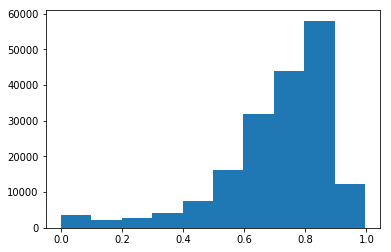

In [33]:
plt.hist(model_pred)
plt.show()

In [34]:
# Confusion matrix for CNN
print("Confusion Matrix for CNN: ")
confusion_matrix(y_test,class_pred)

Confusion Matrix for CNN: 


array([[  6561,  17666],
       [ 13685, 144626]], dtype=int64)

# Support Vector Machine

In [35]:
# a list contains each review as a list 
svc_texts = []
svc_labels = []

for i in range(len(balanced_train)):
    svc_texts.append(balanced_train.iloc[i,1])
    svc_labels.append(balanced_train.iloc[i,0])

In [36]:
# data preproccsing and fit Support Vector Machine
t1 = datetime.now()
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
svc_classifier = LinearSVC()
Xs = vectorizer.fit_transform(svc_texts)
 
print(datetime.now() - t1)
print(Xs.shape)
 
score = cross_val_score(svc_classifier, Xs,svc_labels, cv=2, n_jobs=-1)

print(datetime.now() - t1)
print(score)
print(sum(score) / len(score))

0:03:51.287015
(930302, 1832756)
0:09:45.887177
[0.81257094 0.80957756]
0.8110742500893378


In [37]:
# split data into training and testing sets
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, np.array(svc_labels), test_size=0.4)

In [41]:
svc_classifier.fit(Xs_train, ys_train)

svc_pred = svc_classifier.predict(Xs_test)

In [42]:
jl.dump(svc_classifier, '../../models/fake_review_svc_model.joblib')   # svc = load('fake_review_svc_model.joblib')
jl.dump(vectorizer, "../../models/tfidf_vectorizer.joblib")

['tfidf_vectorizer.pickle']

In [44]:
print("Report for Support Vector Machine:")
print(classification_report(ys_test, svc_pred))

print("Accuracy for lr % :", accuracy_score(ys_test, svc_pred)*100)

Report for Support Vector Machine:
              precision    recall  f1-score   support

          -1       0.84      0.95      0.89    161016
           1       0.96      0.86      0.91    211105

   micro avg       0.90      0.90      0.90    372121
   macro avg       0.90      0.91      0.90    372121
weighted avg       0.91      0.90      0.90    372121

Accuracy for lr % : 89.99142751954338


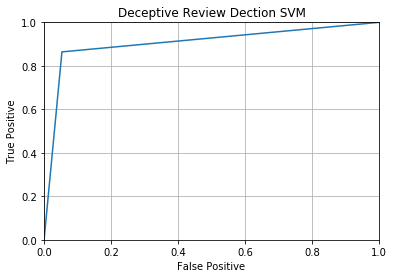

In [45]:
#draw ROC curve
fpr, tpr, thresholds = roc_curve(ys_test,svc_pred)

plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Deceptive Review Dection SVM")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


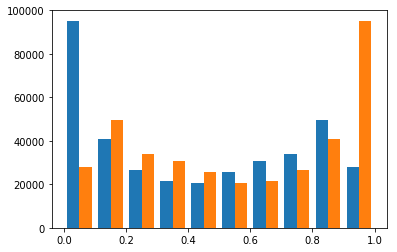

In [46]:
from sklearn.calibration import CalibratedClassifierCV

svc_to_proba = CalibratedClassifierCV(svc_classifier, cv=10)

svc_to_proba.fit(Xs_train, ys_train)

svc_proba = svc_to_proba.predict_proba(Xs_test)

#probability distribution of support vector machine prediction

plt.hist(svc_proba)

plt.show()

In [78]:
cal_svc_pred = binarize(np.array(svc_proba), threshold=0.5)
cal_svc_pred = np.array([1 if (x == [0, 1]).all() else -1 for x in cal_svc_pred])

print("Report for Calibrated Support Vector Machine:")
print(classification_report(ys_test, cal_svc_pred))

print("Accuracy for lr % :", accuracy_score(ys_test, cal_svc_pred)*100)

Report for Calibrated Support Vector Machine:
              precision    recall  f1-score   support

          -1       0.85      0.89      0.87    161016
           1       0.91      0.88      0.90    211105

   micro avg       0.89      0.89      0.89    372121
   macro avg       0.88      0.89      0.88    372121
weighted avg       0.89      0.89      0.89    372121

Accuracy for lr % : 88.62090556566278


In [47]:
#Confusion matrix for SVC before balance the data
print("Confusion Matric for SVC before balance the data: ")
confusion_matrix(ys_test, svc_pred)

Confusion Matric for SVC before balance the data: 


array([[152427,   8589],
       [ 28655, 182450]], dtype=int64)

In [80]:
#Confusion matrix for SVC after balance the data
print("Confusion Matric for SVC after balance the data: ")
confusion_matrix(ys_test, cal_svc_pred)

Confusion Matric for SVC after balance the data: 


array([[143163,  17853],
       [ 24491, 186614]], dtype=int64)

# Predictions On New Data

In [25]:
review = pd.read_csv("review_subset.csv")

In [7]:
review.head()

,business_id,date,review_id,stars,text,user_id
0,jQsNFOzDpxPmOurSWCg1vQ,2017-06-03,ByRzJ8rF2KJWLr-cUNU6EA,1.0,"This place is horrible, we were so excited to ...",kzyLOqiJvyw_FWFTw2rjiQ
1,jQsNFOzDpxPmOurSWCg1vQ,2015-03-26,i5UwUPlQFPLcE8p2gPFwBw,4.0,"For being fairly ""fast"" food.. Pei Wei (pronou...",WZXp9-V2dqRRJqhGgRqueA
2,jQsNFOzDpxPmOurSWCg1vQ,2012-12-30,EyQyvTTg2jX4or9bB8PC9g,5.0,"I decided to try it out, I'm celiac and theref...",XylT12exfdLiI_3uDLVIpw
3,jQsNFOzDpxPmOurSWCg1vQ,2009-01-12,G-EFA005besj5uHsH0sQFA,3.0,I'm not saying Pei Wei is the best asian food ...,Ji9PeffxjwqPLO7pEfSpKQ
4,jQsNFOzDpxPmOurSWCg1vQ,2015-07-11,6PcJSGUBSLjt4VLXos5C4A,3.0,Sometimes the food is spot on and delicious an...,TLIWzAJPrET0zX4_vgvLhg


In [7]:
text = review["text"]

In [19]:
def store_lst(text):
    text = text
    new_texts = []
    for i in range(len(text)):
        new_texts.append(text[i])
    return new_texts

new_texts = store_lst(text)

In [9]:
X = vectorizer.transform(new_texts)

In [12]:
svc_classifier.fit(Xs, svc_labels)

svc_predictions = svc_classifier.predict(X)

In [13]:
y_output = list(svc_predictions)
yp=["True" if a==1 else "Deceptive" for a in y_output]
X_outputlist = list(review["text"])
star = list(review["stars"])
user_id = list(review["user_id"])
business_id = list(review["business_id"])
final_output_fm = pd.DataFrame({"user_id":user_id, "business_id":business_id,"Stars":star,'Review':X_outputlist ,'True(1)/Deceptive(0)':yp})
final_output_fm[final_output_fm["True(1)/Deceptive(0)"]=="Deceptive"]

,Review,Stars,True(1)/Deceptive(0),business_id,user_id
11,I love this place i'd recommend it to anyone !...,5.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,O7G_c6wFXSygr82qs0GAcA
20,I love Pei Wei since it's just a bit more affo...,4.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,PKZLwAGgBtQCjJtGhyPETA
29,Everything was good except Thai chicken wraps....,3.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,alTlRb9qMBX11pARX05Big
45,I love their food. I have gone there multiple ...,5.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,gRhtEXoxVpaccgvr3OkC0A
47,Very tasty Chinese food! The prices are reaso...,3.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,faaOI6hU64h6SSaF0f11eg
52,Took the family there last week. Ordered frie...,2.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,QZmG0pJlPQUq0PudwDKI5g
68,"Absolutely wonderful. This place is clean, the...",5.0,Deceptive,jQsNFOzDpxPmOurSWCg1vQ,IFBx9nPxyomWzj_2prR6bg
89,We've eaten here 2-3 times a month for the las...,5.0,Deceptive,dwQEZBFen2GdihLLfWeexA,8e2Khf95bZgBlkeMqh59fA
101,"Good food, great prices, large portions, fast,...",5.0,Deceptive,dwQEZBFen2GdihLLfWeexA,is6jBVBI3fbjFOCD9cJwvA
108,This is our go to Mexican restaurant. The staf...,5.0,Deceptive,dwQEZBFen2GdihLLfWeexA,ludX46lEfeQ8TuHsK0D9zw


In [14]:
final_output_fm.to_csv('svc_predictions.csv',index=False,encoding= 'utf-8')